# Searching for New Particle Resonances

*Students will “discover” a new particle by characterising a resonant bump in the invariant mass distribution from a set of simulated particle collisions.*

**Topics: data processing (raw data → histograms), curve fitting, regression Relevant packages: NumPy, SciPy, Matplotlib**

Students will be provided with a simulated dataset coming from a $pp \rightarrow X(\rightarrow ab)cd$ decay. The dataset will consist of a list the daughter particles' 4-momenta and charges. Students will plot the invariant mass of the mother particle and observe by eye a resonant “bump” corresponding to the mother particle.

Students will then write their own regression-based curve-fitting code to fit the background and resonant distributions, thus determining the mother particle mass and decay width. For a more particle physics-specific tangent, students might look into common curve-fit functions (i.e. Gaussian, Landau, Crystal Ball) and understand when a given functional form is most useful. Once students are happy with the performance of their curve-fitting tool, they will redo the analysis using scipy.optimize (which is a useful module for them to know for future research analyses).

In [15]:
import numpy as np
import matplotlib.pyplot as plt

path_to_data = "test.txt"

# 1

First, write a python function that will read in the particle collision data from the provided text file.

The first few lines of the data file will look something like:

```
E px py pz charge

<event>
1.27893787226 -0.967943427485 -0.196782063814 0.4972631904 1
0.65484957674 0.0799580860542 0.085630174222 0.621646982287 -1
1.07972424322 -0.634807604926 -0.394274396233 -0.750563397282 -1
1.73527280522 1.42962557946 0.48622159803 -0.272846669269 1
</event>

```

The very first line of the file is a header telling you what information is provided for each particle.

Collision events begin with a line ```<event>``` and end with a line ```</event>```. Each line in a given event represents a particle.

In [16]:
# Write your function here

def read_in_particle_data(path_to_file):

    """
    INPUTS:
    
    filename: a string containing the absolute filepath to the collision dataset
    
    **********
    **********
    
    OUTPUTS: 
    
    dict_of_events: a dictionary of the collision events of the form {event_id: [p4_a, p4_b, p4_c, p4_d]}
                        Each p4_i is a list of floats containing the 4-momenta and charge [E, px, py, pz, charge]
    
    """
    
    dict_of_events = {}
    
    event_counter = 0
    
    with open(path_to_file) as infile:
        for line in infile:
            
            if "<event>" in line:
                dict_of_events[event_counter] = []
                
            elif "</event>" in line:
                event_counter += 1
                
            else:
                try: 
                    test_digit = float(line.split()[0]) # testing to see if the first value in the line is a number
                    p_vec = [float(x) for x in line.split()]
                    dict_of_events[event_counter].append(p_vec)
                except:
                    pass
          
    return dict_of_events


In [29]:
# Execute your function here

dict_of_events = read_in_particle_data(path_to_data)

N_collisions = len(dict_of_events)


[[1.44047663667, -1.34389608816, -0.207387575397, 0.102709607188, -1.0], [0.760045206693, 0.316215424657, -0.272251487404, 0.0718892382524, 1.0], [1.38026990394, 0.329953369344, 1.08812733857, -0.680703186442, 1.0], [1.0432631583, 0.718063519452, -0.537768800051, 0.511091920335, -1.0]]


# 2

Now, we need to get a sense of what our dataset looks like! How energetic are the particles? Are they distributed relatively evenly in momentum space? What symmetries do these collision events seem to obey?

Plot histograms of the energy and momenta of the daughter particles. Comment briefly on their distributions (perhaps address the three questions in the previous line).

Note: we're going to be making a lot of histograms in this notebook. It might be useful to write a function that can quickly make nice-looking histograms so you don't have to explicitly type out the same formatting-related lines multiple times.


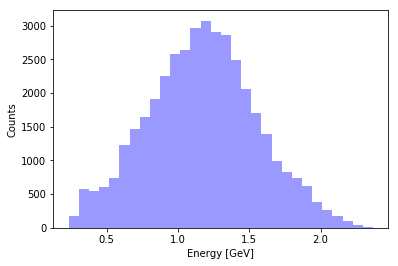

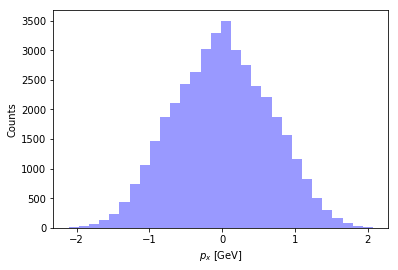

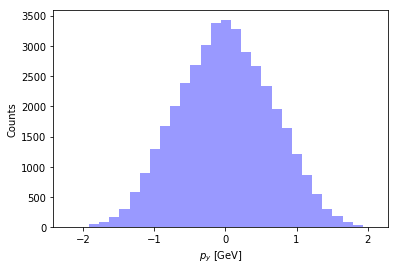

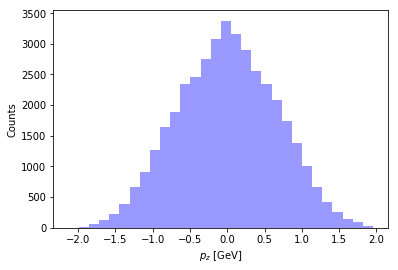

In [27]:
# Write your code here

all_E = []
all_px = []
all_py = []
all_pz = []


for i in range(N_collisions):
    
    event_E = [particle[0] for particle in dict_of_events[i]]
    event_px = [particle[1] for particle in dict_of_events[i]]
    event_py = [particle[2] for particle in dict_of_events[i]]
    event_pz = [particle[3] for particle in dict_of_events[i]]
    
    all_E.extend(event_E)
    all_px.extend(event_px)
    all_py.extend(event_py)
    all_pz.extend(event_pz)
    
    
def plot_histogram(observables, bins, xlabel):

    """
    INPUTS:
    
    observables: a list of floats (or ints) containing the data to be histogrammed
    
    bins: a np.array containing the histogram bin edges
    
    xlabel: a string of the histogram x-axis label
    
    **********
    **********
    
    OUTPUTS: 
    
    None
    
    """

    plt.figure()
    plt.hist(observables, bins, color = "blue", alpha = .4)
    plt.xlabel(xlabel)
    plt.ylabel("Counts")
    plt.show()


plot_histogram(all_E, 30, "Energy [GeV]")
plot_histogram(all_px, 30, "$p_x$ [GeV]")
plot_histogram(all_py, 30, "$p_y$ [GeV]")
plot_histogram(all_pz, 30, "$p_z$ [GeV]")

Most particle physics analyses do not use $E$, $p_x$, $p_y$, and $p_z$ as the variables for analysis. Instead, it is easier to analyze the variables $p_T$ (the momentum component transverse to the beam axis), $y$ (rapidity), and $\phi$.

Created histograms of these three variables. (You will may have to look up the definitions of these variables in terms of the Cartesian 4-momenta). Comment briefly on their distributions.

In [30]:
def calculate_coords(event):
    
    """
    INPUTS:
    
    event: a list of lists [p4_a, p4_b, p4_c, p4_d] corresponding to a given collision event.
            Each p4_i is a list of floats containing the 4-momenta and charge [E, px, py, pz, charge]
    
    **********
    **********
    
    OUTPUTS: 
    
    collision_pT: a list of the transverse momenta for each of the daughter particles
                    collision_y, collision_phi are defined similarly
    
    
    """
    
    collision_pT = []
    collision_y = []
    collision_phi = []
    
    for particle in event: 
        pT = np.sqrt(particle[1]**2 + particle[2]**2)
        if ((particle[0]+particle[3])/(particle[0]-particle[3])) > 0:
            y = (0.5)*np.log((particle[0]+particle[3])/(particle[0]-particle[3]))
        else:
            y = 0
        phi = np.arctan2(particle[2], particle[1])
        
        collision_pT.append(pT)
        collision_y.append(y)
        collision_phi.append(phi)
        
    return collision_pT, collision_y, collision_phi

all_pT = []
all_y = []
all_phi = []

for i in range(N_collisions):
    collision_pT, collision_y, collision_phi = calculate_coords(dict_of_events[i])
    all_pT.extend(collision_pT)
    all_y.extend(collision_y)
    all_phi.extend(collision_phi)
    
    

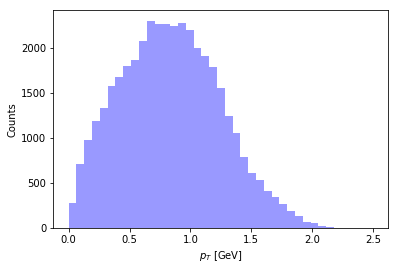

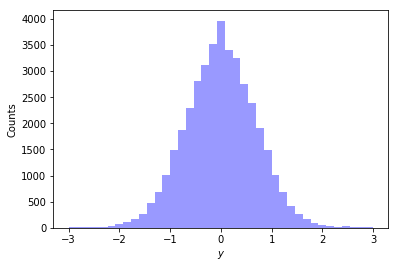

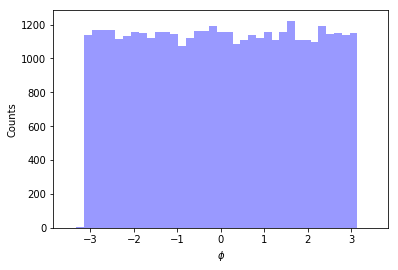

In [31]:
# Write your plotting code here

pT_bins = np.linspace(0,2.5,40)
y_bins = np.linspace(-3,3,40)
phi_bins = np.linspace(-3.5,3.5,40)


plot_histogram(all_pT, pT_bins, "$p_T$ [GeV]")
plot_histogram(all_y, y_bins, "$y$")
plot_histogram(all_phi, phi_bins, "$\phi$")

# 3 

Now we want to calculate the mass of the resonant particle $X$ that was produced in the collision event. However, we don't know which two of the four particles in each event decayed from $X$. We do, however, know that $X$ is a neutral particle.

For every valid combination of daughter particles that could have come from a decay of $X$, calculate the hypothetical mass of $X$. Then plot a histgram of all of the invariant masses and make a guess at what the true mass of $X$ is.

In [35]:
def calculate_m2(particle1, particle2):
    
    """
    INPUTS:
    
    particle1: a list [E, px, py, pz] of 4-momentum components 
    particle2: a list [E, px, py, pz] of 4-momentum components 
    
    **********
    **********
    
    OUTPUTS: 
    
    m: A float of the invariant mass of a hypothetical mother particle that could have decayed into particle1 + particle2
    
    """
    
        
    E = particle1[0] + particle2[0]
    px = particle1[1] + particle2[1] 
    py = particle1[2] + particle2[2]
    pz = particle1[3] + particle2[3]
    m2 = E**2 - px**2 - py**2 - pz**2
    
    if m2 > 0:
        return np.sqrt(m2) 
    else:
        return 0


def get_event_invariant_masses(event):
    
    """
    INPUTS:
    
    event: a list of 4-momenta
    
    **********
    **********
    
    OUTPUTS: 
    
    masses: a list of the hypothetical invariant masses of the particle X
    
    """
         
    positives = []
    negatives = []
    
    for particle in event:
        if particle[-1] < 0:
            negatives.append(particle)
        elif particle[-1] > 0: 
            positives.append(particle)

    masses = []
    
    
    masses.append(calculate_m2(positives[0], negatives[0]))
    masses.append(calculate_m2(positives[0], negatives[1]))
    masses.append(calculate_m2(positives[1], negatives[0]))
    masses.append(calculate_m2(positives[1], negatives[1]))    
    
    return masses


In [36]:
# Execute your code here
    
all_mX = []

for i in range(N_collisions):
    
    all_mX.extend(get_event_invariant_masses(dict_of_events[i]))
  

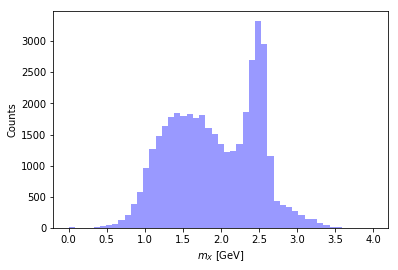

In [37]:
mX_bins = np.linspace(0,4,50)

plot_histogram(all_mX, mX_bins, "$m_X$ [GeV]")

# 4

Of course, estimating $m_X$ by eye is not at all rigorous. We should curve fit the invariant mass distribution, then extract the mean of the fit curve. 

We're going to use ```scipy.optimize.curvefit``` to do this.

We'll start by defining the form of the curve that we want to fit to the invariant mass distribution. In the vast majority of such cases in particle physics, we can approximate the "bump" corresponding to the resonant particle by a Gaussian, and the background by an exponential decay.

Define a function for this distribution below. 

As a starting hint: your "background" fit exponential should have the form $f(m) = N_b \times e^{-\alpha m}$. There are two free parameters: $N_b$ is a normalization constant, and $\alpha$ is the decay constant.

In [41]:
def gaussian(x, mu, sigma):
    return np.exp(-((x-mu)/sigma)**2/2.0)
    
def exponential(x, a):
    return np.exp(-x*a)

def model_fit(x, mu, sigma, a, N_sig, N_bkg):
    return N_sig*gaussian(x, mu, sigma) + N_bkg*exponential(x, a)

Now we need to extract the $x$- (invariant mass $m_X$) and $y$- (Counts) coordinates of the curve that we want ```scipy.optimize``` to fit to. Write a function to do so below.

Note: you will probably find that the leftmost bin edge should *not* be at $m = 0$ in order for the Gaussian + exponential fit function to be applicable.

In [54]:
def extract_curve_from_histgram(observables, bin_edges):
    
    """
    INPUTS:
    
    observables: a list of floats (or ints) containing the data to be histogrammed
    
    bins: a np.array containing the histogram bin edges
    
    **********
    **********
    
    OUTPUTS: 
    
    bin_centers: a np.array of the bin 
    
    counts_y_data: a np.array of the histogram counts for each bin
    
    """
    
    hist, bin_edges = np.histogram(observables, bin_edges)
    
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    
    return bin_centers, hist

  
mX_bins_adj = np.linspace(1.8,3.4,50)

x_data, y_data = extract_curve_from_histgram(all_mX, mX_bins_adj)

Finally, use ```scipy.optimize.curve_fit``` to fit the histogram data to the model function. Make a plot contaning both the histogram for $m_X$, and the best-fit model function found by ```scipy.optimize.curve_fit```. Also print out the best-fit value for $m_X$ along with the uncertainty on the measurement. 

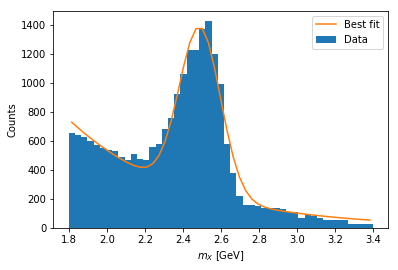

Best estimate for $m_X$: 2.49009815817 +/- 0.00352873881579 GeV


In [55]:
from scipy.optimize import curve_fit

p0 = [2, .05, -1, 1000, 1000]

popt, pcov = curve_fit(model_fit, x_data, y_data, p0 = p0)
errors = np.sqrt(np.diag(pcov))

plt.figure()
plt.hist(all_mX, bins = mX_bins_adj, label = "Data")
plt.plot(x_data, model_fit(x_data, *popt), label = "Best fit")
plt.xlabel("$m_X$ [GeV]")
plt.ylabel("Counts")
plt.legend()
plt.show()

print("Best estimate for $m_X$:", popt[0], "+/-", errors[0], "GeV")

# 5

As mentioned above, the vast majority of particle resonances can be modeled by a Gaussian. However, other functional forms for "bumps" exist that better model lossy processes (i.e. those where the tail of the distribution doesn't fall off as sharply as it does for a Gaussian).

Repeat the above curve fitting analysis, but swap out the Gaussian signal function with a Crystal Ball distribution. Comment on the "goodness" of the fit with a Crystal Ball distribution compared with that of a Gaussian.



In [95]:
def CB(x, mu, sigma, beta, n):
   
    
    def CB_gaussian(x_loc):
        return np.exp(-((x_loc-mu)/sigma)**2/2.0)
    
    def CB_decay(x_loc):
        return ((n/np.abs(beta))**n)*(np.exp(-beta**2/2))*((n/np.abs(beta))-np.abs(beta)-((x_loc-mu)/sigma))**(-n)
    
    x = np.array([CB_gaussian(x_loc) if ((x_loc-mu)/sigma) > -beta else CB_decay(x_loc) for x_loc in x ])

    return x

def model_fit_CB(x, mu, sigma, beta, n, a, N_sig, N_bkg):
     return N_sig*CB(x, mu, sigma, beta, n) + N_bkg*exponential(x, a) 
    
    

/global/common/cori/software/python/3.6-anaconda-5.2/lib/python3.6/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars
/global/common/cori/software/python/3.6-anaconda-5.2/lib/python3.6/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: overflow encountered in double_scalars


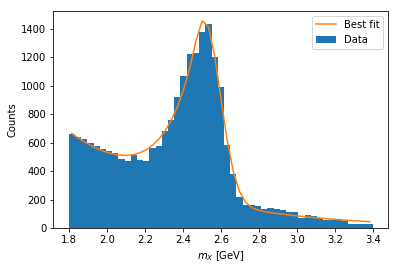

Best estimate for $m_X$: 2.51329465428 +/- 0.00339418948205 GeV


In [96]:
p0 = [2.5, .05, 2.2, 2, 1, 1000, 1000]

popt, pcov = curve_fit(model_fit_CB, x_data, y_data, p0 = p0)
errors = np.sqrt(np.diag(pcov))

plt.figure()
plt.hist(all_mX, bins = mX_bins_adj, label = "Data")
plt.plot(x_data, model_fit_CB(x_data, *popt), label = "Best fit")
plt.xlabel("$m_X$ [GeV]")
plt.ylabel("Counts")
plt.legend()
plt.show()

print("Best estimate for $m_X$:", popt[0], "+/-", errors[0], "GeV")